# Simulating the Deutsch–Jozsa algorithm at the pulse level

The Deutsch-Jozsa algorithm is a quantum algorithm that solves a problem of determining the constant or balanced nature of a function with one input bit and one output bit in one step. It can be implemented at the pulse level by representing quantum states as pulses in a quantum information processing system.

---------

 The algorithm works by creating superpositions of input states, applying the function to the superpositions, and measuring the output to determine the nature of the function. At the pulse level, this is achieved through the use of quantum gates and pulses that manipulate the state of qubits in a quantum computer. By simulating the Deutsch-Jozsa algorithm at the pulse level, one can gain a deeper understanding of how quantum algorithms work and explore the capabilities and limitations of quantum computing.

In this example, we demonstrate how to simulate simple quantum algorithms on a qauntum hardware with QuTiP. The simulators are defined in the class `Processor`(and its sub-classes). `Processor` represents a general quantum device. The interaction of the quantum systems such as qubits is defined by the control Hamiltonian

## Deutsch-Jozsa

The Deutsch-Jozsa algorithm is based on the quantum mechanical concept of superposition and the quantum gate operation. It can be mathematically described as follows:

Let us assume there is a function $f(x)$ which maps binary inputs $x$ to binary outputs $y$ such that $f(x) \in {0,1}$. The goal is to determine whether $f(x)$ is a constant function or a balanced function, i.e., whether $f(x) = 0$ or $f(x) = 1$ for all $x$, or whether $f(x) = 0$ for half of the possible values of $x$ and $f(x) = 1$ for the other half.

The Deutsch-Jozsa algorithm solves this problem by constructing a quantum superposition of all possible input states:

$\frac{1}{\sqrt{2^{n}}} \sum\limits_{x=0}^{2^n - 1} \left|x\right\rangle \left|0\right\rangle$

where $n$ is the number of qubits used to represent $x$.

Next, the function $f(x)$ is applied to the superposition, which can be described as a unitary transformation $U_f$:

$\frac{1}{\sqrt{2^{n}}} \sum\limits_{x=0}^{2^n - 1} \left|x\right\rangle \left|f(x)\right\rangle$

Finally, the resulting state is measured, and the result determines the nature of the function $f(x)$. If $f(x)$ is constant, the measurement result will always be $\left|0\right\rangle$, and if $f(x)$ is balanced, the measurement result will be either $\left|0\right\rangle$ or $\left|1\right\rangle$ with equal probability.

In summary, the Deutsch-Jozsa algorithm uses the principles of quantum mechanics to solve the problem of determining the constant or balanced nature of a function with a single quantum step, whereas classical algorithms would require two evaluations of the function.





In [1]:
%pip install qutip
%pip install qutip_qip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 40.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 KB 1.4 MB/s eta 0:00:00


In [2]:
import numpy as np
from qutip_qip.device import OptPulseProcessor, LinearSpinChain, SpinChainModel, SCQubits
from qutip_qip.circuit import QubitCircuit
from qutip import sigmaz, sigmax, identity, tensor, basis, ptrace

In [3]:
qc = QubitCircuit(N=3)
qc.add_gate("X", targets=2)
qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)
qc.add_gate("SNOT", targets=2)

# function f(x)
qc.add_gate("CNOT", controls=0, targets=2)
qc.add_gate("CNOT", controls=1, targets=2)

qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)

## Using the spin chain model
First, we simulate the quantum circuit using the Hamiltonian model LinearSpinChain. The control Hamiltonians are defined in SpinChainModel.

In [4]:
processor = LinearSpinChain(3)
processor.load_circuit(qc);

To quickly visualize the pulse, Processor has a method called plot_pulses. In the figure bellow, each colour represents the pulse sequence of one control Hamiltonian in the system as a function of time. In each time interval, the pulse remains constant.

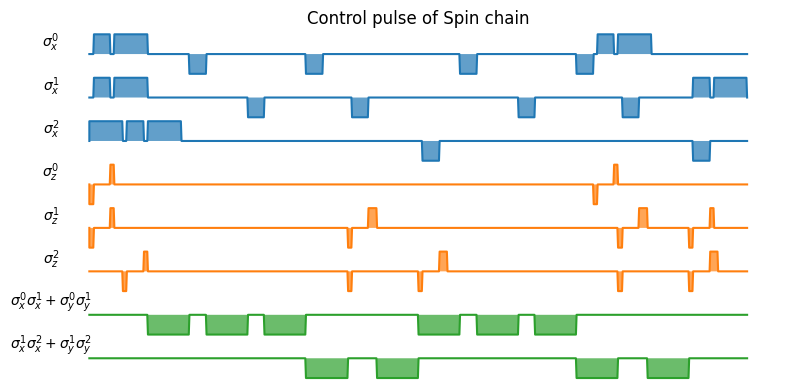

In [5]:
processor.plot_pulses(title="Control pulse of Spin chain", figsize=(8, 4), dpi=100);


Because for the spin chain model interaction only exists between neighbouring qubits, SWAP gates are added between and after the first CNOT gate, swapping the first two qubits. The SWAP gate is decomposed into three iSWAP gates, while the CNOT is decomposed into two iSWAP gates plus additional single-qubit corrections. Both the Hadamard gate and the two-qubit gates need to be decomposed to native gates (iSWAP and rotation on the x
 and z
 axes). The compiled coefficients are square pulses and the control coefficients on σz
 and σx
 are also different, resulting in different gate times.

## Without decoherence

In [6]:
basis00 = basis([2,2], [0,0])
psi0 = basis([2,2,2], [0,0,0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
1.5448296054999982e-08


## With decoherence

In [7]:
processor.t1 = 100
processor.t2 = 30
psi0 = basis([2,2,2], [0,0,0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
0.13730233392886707


## Using the optimal control module
This feature integrated into the sub-class OptPulseProcessor which use methods in the optimal control module to find the optimal pulse sequence for the desired gates. It can find the optimal pulse either for the whole unitary evolution or for each gate. Here we choose the second option.

In [8]:
setting_args = {"SNOT": {"num_tslots": 6, "evo_time": 2},
                "X": {"num_tslots": 1, "evo_time": 0.5},
                "CNOT": {"num_tslots": 12, "evo_time": 5}}
processor = OptPulseProcessor(  # Use the control Hamiltonians of the spin chain model.
    num_qubits=3, model=SpinChainModel(3, setup="linear"))
processor.load_circuit(  # Provide parameters for the algorithm
    qc, setting_args=setting_args, merge_gates=False,
    verbose=True, amp_ubound=5, amp_lbound=0);

********** Gate 0 **********
Final fidelity error 0.33197815751246784
Final gradient normal 0.00012782930789713808
Terminated due to function converged
Number of iterations 56
********** Gate 1 **********
Final fidelity error 0.004788501579034321
Final gradient normal 0.014002379156202664
Terminated due to Iteration or fidelity function call limit reached
Number of iterations 500
********** Gate 2 **********
Final fidelity error 1.3573819845902335e-09
Final gradient normal 7.762731325727278e-05
Terminated due to function converged
Number of iterations 76
********** Gate 3 **********
Final fidelity error 0.010183702336737266
Final gradient normal 0.013444304138058655
Terminated due to function converged
Number of iterations 193
********** Gate 4 **********
Final fidelity error 1.7065292290396883e-08
Final gradient normal 0.00011526742777197991
Terminated due to function converged
Number of iterations 148
********** Gate 5 **********
Final fidelity error 1.8133159640498775e-08
Final grad

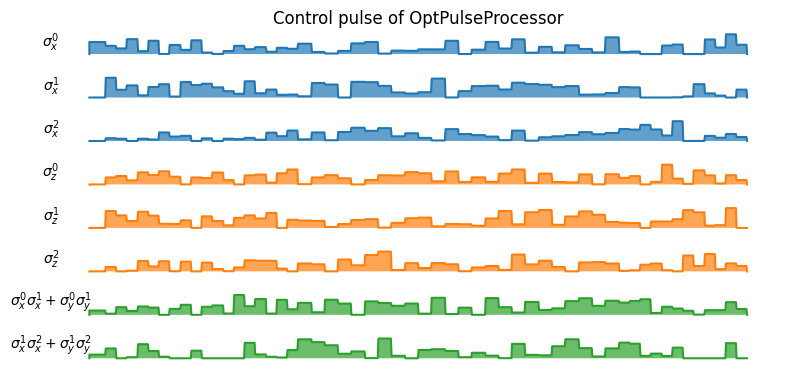

In [9]:
processor.plot_pulses(title="Control pulse of OptPulseProcessor", figsize=(8, 4), dpi=100);


For the optimal control model, we use the GRAPE algorithm, where control pulses are piece-wise constant functions. We provide the algorithm with the same control Hamiltonian model used for the spin chain model. In the compiled optimal signals, all controls are active (non-zero pulse amplitude) during most of the execution time. We note that for identical gates on different qubits (e.g., Hadamard), each optimized pulse is different, demonstrating that the optimized solution is not unique, and there are further constraints one could apply, such as adaptions for the specific hardware.

## Without Decoherence

In [10]:
basis00 = basis([2,2], [0,0])
psi0 = basis([2,2,2], [0,0,0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
0.23717139021684985


## With decoherence

In [11]:
processor.t1 = 100
processor.t2 = 30
psi0 = basis([2,2,2], [0,0,0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
0.2510328791120197


We can see that under noisy evolution their is a none zero probability of measuring state 00.

## Using the superconducting qubits model
Below, we simulate the same quantum circuit using one sub-class LinearSpinChain. It will find the pulse based on the Hamiltonian available on a quantum computer of the linear spin chain system. Please refer to the notebook of the spin chain model for more details.

In [12]:
processor = SCQubits(num_qubits=3)
processor.load_circuit(qc);

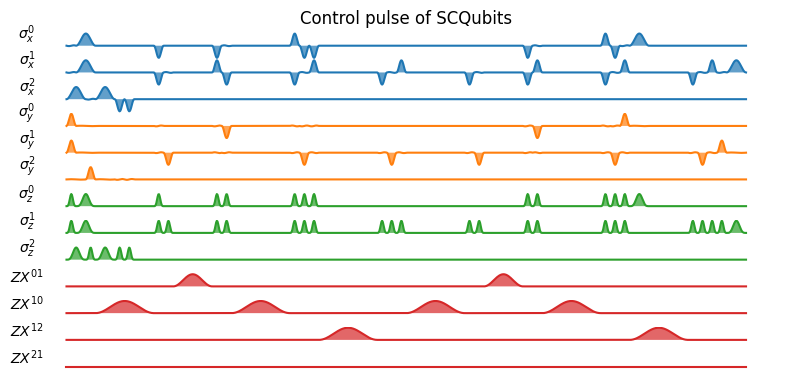

In [13]:
processor.plot_pulses(title="Control pulse of SCQubits", figsize=(8, 4), dpi=100);


For the superconducting-qubit processor, the compiled pulses have a Gaussian shape. This is crucial for superconducting qubits because the second excited level is only slightly detuned from the qubit transition energy. A smooth pulse usually prevents leakage to the non-computational subspace. Similar to the spin chain, SWAP gates are added to switch the zeroth and first qubit and one SWAP gate is compiled to three CNOT gates. The control ZX21
 is not used because there is no CNOT gate that is controlled by the second qubit and acts on the first one.

## Without decoherence

In [14]:
basis00 = basis([3, 3], [0, 0])
psi0 = basis([3, 3, 3], [0, 0, 0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
3.0313566972800095e-07


## With decoherence

In [15]:
processor.t1 = 50.e3
processor.t2 = 20.e3
psi0 = basis([3, 3, 3], [0, 0, 0])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
0.06044432839286006


## Software Versions

In [16]:
import qutip_qip
print("qutip-qip version:", qutip_qip.version.version)
from qutip.ipynbtools import version_table
version_table()

qutip-qip version: 0.2.3


Software,Version
QuTiP,4.7.1
Numpy,1.21.6
SciPy,1.7.3
matplotlib,3.2.2
Cython,0.29.33
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,7.9.0
Python,"3.8.10 (default, Nov 14 2022, 12:59:47) [GCC 9.4.0]"
OS,posix [linux]
